In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, hamming_loss
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup 
import torch
from torch import nn  
from torch.utils.data import Dataset, DataLoader  
from scipy.sparse import csr_matrix
from tqdm import tqdm  # For live progress updates
import logging
import spacy
import optuna
from focal_loss import BinaryFocalLoss
import shap
from lime.lime_text import LimeTextExplainer
import joblib
from negspacy.negation import Negex  # For advanced negation handling
from negspacy.termsets import termset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import coverage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)  


# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Load spaCy model
nlp = spacy.load("en_core_sci_sm")
ts = termset("en_clinical")
nlp.add_pipe("negex", config={"neg_termset": ts.get_patterns()})

2024-09-17 02:02:08,128 - INFO - Using device: cuda


In [108]:
# Cell 2: Data Loading and Merging
def load_and_merge_data(file_paths):
    try:
        logger.info("Loading data files...")
        radiology_df = pd.read_csv(file_paths[0], usecols=['subject_id', 'note_id', 'hadm_id', 'text'])
        radiology_detail_df = pd.read_csv(file_paths[1], usecols=['subject_id', 'note_id', 'field_name', 'field_value'])
        diagnoses_icd_df = pd.read_csv(file_paths[2], usecols=['subject_id', 'hadm_id', 'icd_code'])
        patients_df = pd.read_csv(file_paths[3], usecols=['subject_id', 'gender', 'anchor_age'])
        admissions_df = pd.read_csv(file_paths[4], usecols=['subject_id', 'hadm_id', 'admission_type', 'insurance'])

        logger.info("Files loaded successfully")

        radiology_df.drop_duplicates(subset=['subject_id', 'note_id'], inplace=True)
        radiology_detail_df.drop_duplicates(subset=['subject_id', 'note_id'], inplace=True)
        diagnoses_icd_df.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)
        patients_df.drop_duplicates(subset=['subject_id'], inplace=True)
        admissions_df.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)

        # Filter for top 10 most frequent ICD codes
        icd_counts = diagnoses_icd_df['icd_code'].value_counts()
        top_10_icd = icd_counts.head(10).index.tolist()
        diagnoses_icd_df = diagnoses_icd_df[diagnoses_icd_df['icd_code'].isin(top_10_icd)]

        logger.info("Merging dataframes...")
        df = pd.merge(radiology_df, radiology_detail_df, on=['subject_id', 'note_id'], how='inner')
        df = pd.merge(df, diagnoses_icd_df, on=['subject_id', 'hadm_id'], how='inner')
        df = pd.merge(df, patients_df, on=['subject_id'], how='inner')
        df = pd.merge(df, admissions_df, on=['subject_id', 'hadm_id'], how='inner')

        logger.info("Dataframes merged successfully")
        return df

    except Exception as e:
        logger.error(f"Error: {e}")
        return None

file_paths = [
    'radiology.csv',
    'radiology_detail.csv',
    'diagnoses_icd.csv',
    'patients.csv',
    'admissions.csv'
]

df = load_and_merge_data(file_paths)
df.head()

2024-09-17 06:00:59,818 - INFO - Loading data files...
2024-09-17 06:02:01,406 - INFO - Files loaded successfully
2024-09-17 06:02:04,015 - INFO - Merging dataframes...
2024-09-17 06:02:06,677 - INFO - Dataframes merged successfully


,note_id,subject_id,hadm_id,text,field_name,field_value,icd_code,gender,anchor_age,admission_type,insurance
0,10001338-RR-39,10001338,29335220.0,INDICATION: Chest pressure. Please evaluate ...,exam_code,C11,78650,F,43,EU OBSERVATION,Private
1,10001884-RR-100,10001884,25758848.0,HISTORY: Cough and shortness of breath with r...,exam_code,C11,486,F,68,EU OBSERVATION,Medicare
2,10001884-RR-82,10001884,21268656.0,INDICATION: ___ female with chest pain.\n\n__...,exam_code,C11,41401,F,68,EW EMER.,Medicare
3,10001884-RR-83,10001884,26679629.0,CHEST RADIOGRAPH PERFORMED ON ___\n\nCompariso...,exam_code,C11,78659,F,68,EW EMER.,Medicare
4,10001884-RR-97,10001884,26812645.0,"INDICATION: Intermittent chest pain, evaluate...",exam_code,C11,78650,F,68,EU OBSERVATION,Medicare


In [109]:
# Cell 3: Text Preprocessing
def preprocess_text(text):
    doc = nlp(text.lower())
    negex = nlp.get_pipe("negex")
    negated_tokens = []
    for ent in doc.ents:
        if ent._.negex:
            negated_tokens.append("NOT_" + ent.text)
        else:
            negated_tokens.append(ent.text)
    return ' '.join(negated_tokens)

def preprocess_data(df):
    tqdm.pandas()

    logger.info("Preprocessing data...")
    df['processed_text'] = df['text'].progress_apply(preprocess_text)
    df['icd_codes'] = df['icd_code'].str.split(',')
    df = df.dropna(subset=['icd_codes'])
    df['anchor_age'] = pd.to_numeric(df['anchor_age'], errors='coerce')
    
    numeric_columns = ['anchor_age']
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    categorical_columns = ['gender', 'admission_type', 'insurance']
    df = pd.get_dummies(df, columns=categorical_columns)

    logger.info(f"Preprocessed dataset shape: {df.shape}")
    return df

df = preprocess_data(df)
df.head()


2024-09-17 06:02:07,045 - INFO - Preprocessing data...
100%|████████████████████████████████████████████████████████████████████████████| 73461/73461 [25:35<00:00, 47.85it/s]
2024-09-17 06:27:42,530 - INFO - Preprocessed dataset shape: (73461, 26)


,note_id,subject_id,hadm_id,text,field_name,field_value,icd_code,anchor_age,processed_text,icd_codes,...,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,insurance_Medicaid,insurance_Medicare,insurance_No charge,insurance_Other,insurance_Private
0,10001338-RR-39,10001338,29335220.0,INDICATION: Chest pressure. Please evaluate ...,exam_code,C11,78650,-1.296402,indication please evaluate NOT_acute process c...,[78650],...,True,False,False,False,False,False,False,False,False,True
1,10001884-RR-100,10001884,25758848.0,HISTORY: Cough and shortness of breath with r...,exam_code,C11,486,0.307635,shortness recent cold evaluate NOT_pulmonary e...,[486],...,True,False,False,False,False,False,True,False,False,False
2,10001884-RR-82,10001884,21268656.0,INDICATION: ___ female with chest pain.\n\n__...,exam_code,C11,41401,0.307635,indication female chest pain pa lateral lungs ...,[41401],...,False,True,False,False,False,False,True,False,False,False
3,10001884-RR-83,10001884,26679629.0,CHEST RADIOGRAPH PERFORMED ON ___\n\nCompariso...,exam_code,C11,78659,0.307635,chest radiograph comparison chest radiograph _...,[78659],...,False,True,False,False,False,False,True,False,False,False
4,10001884-RR-97,10001884,26812645.0,"INDICATION: Intermittent chest pain, evaluate...",exam_code,C11,78650,0.307635,indication evaluate NOT_pneumonia comparison _...,[78650],...,True,False,False,False,False,False,True,False,False,False


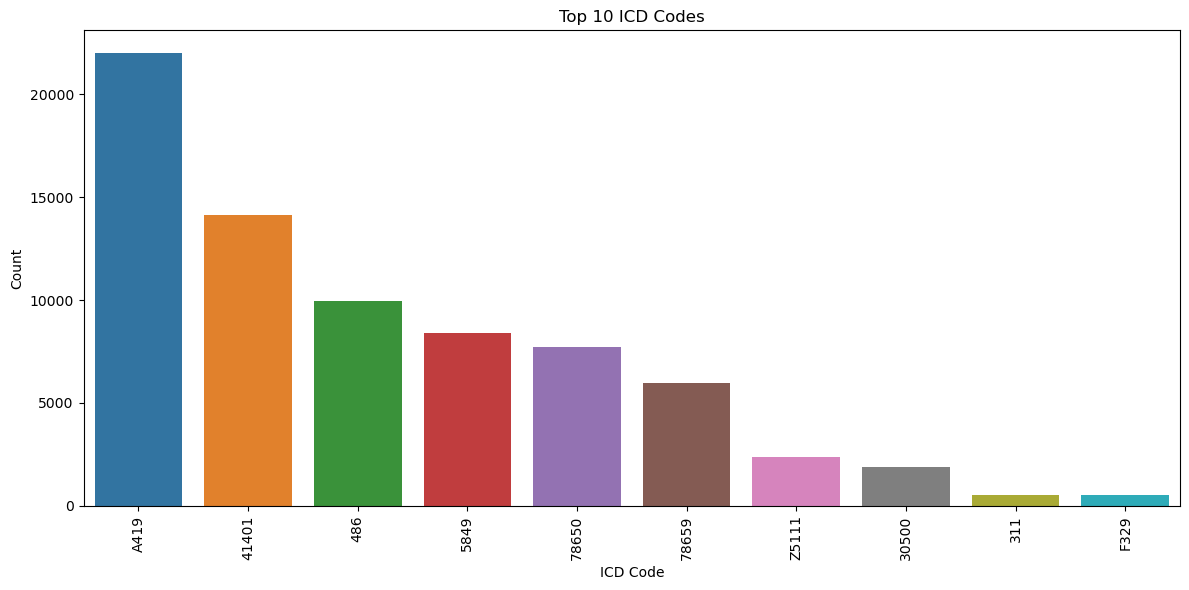

C:\Users\Sabarinath\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


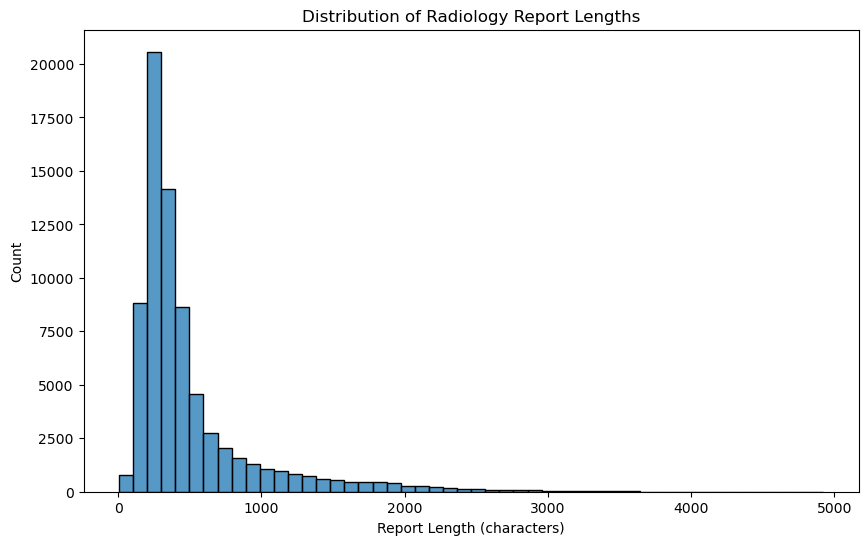

In [117]:
# Cell 4: Exploratory Data Analysis (EDA)
def perform_eda(df):
    icd_counts = df['icd_codes'].explode().value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=icd_counts.index[:20], y=icd_counts.values[:20])
    plt.title('Top 10 ICD Codes')
    plt.xlabel('ICD Code')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    df['report_length'] = df['processed_text'].str.len()
    plt.figure(figsize=(10, 6))
    sns.histplot(df['report_length'], bins=50)
    plt.title('Distribution of Radiology Report Lengths')
    plt.xlabel('Report Length (characters)')
    plt.ylabel('Count')
    plt.show()

perform_eda(df)

In [118]:
# Cell 5: Get PubMedBERT Embeddings
def get_pubmedbert_embeddings(texts, model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    # Ensure that input is always a list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()  # Convert from numpy array to list
    if isinstance(texts, str):
        texts = [texts]  # Convert single string to a list
    elif not isinstance(texts, list):
        raise ValueError("Input must be a string, a list of strings, or a numpy array of strings.")

    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size]
            # Tokenize and generate embeddings
            inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

df['embeddings'] = list(get_pubmedbert_embeddings(df['processed_text'].tolist()))


C:\Users\Sabarinath\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating embeddings: 100%|███████████████████████████████████████████████████████| 4592/4592 [06:28<00:00, 11.81it/s]


In [119]:
# Cell 6: Attention Mechanism and Model Definition
# RadiologyDataset class definition
class RadiologyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(np.vstack(features), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# AttentionLayer class definition
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        attention_scores = self.attention_weights(x)  # Shape: [batch_size, seq_len, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)  # Softmax over seq_len
        weighted_sum = torch.sum(x * attention_weights, dim=1)  # Weighted sum across seq_len
        return weighted_sum, attention_weights  # Shape: [batch_size, input_dim]

# ICDClassifierWithAttention class definition
class ICDClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ICDClassifierWithAttention, self).__init__()
        self.attention = AttentionLayer(input_dim)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),  # input_dim must be 768 (PubMedBERT embedding size)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # num_classes is the output size for multi-label classification
        )

    def forward(self, x):
        # Apply attention mechanism
        x, attention_weights = self.attention(x)
        
        # Ensure the tensor has the right shape before the fully connected layer
        if len(x.shape) == 3:
            # Squeeze the sequence length dimension
            x = x.squeeze(1)
        
        # Pass through the fully connected layers
        output = self.fc(x)  # Input to FC should be [batch_size, input_dim=768]
        
        return output, attention_weights

# FocalLoss class definition
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            F_loss = alpha_t * F_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [120]:
# Cell 7: Train/Test Split 
def prepare_datasets(df, test_size=0.2, random_state=42):
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['icd_codes'])

    X_train, X_test, y_train, y_test = train_test_split(
        df['embeddings'].tolist(), y, test_size=test_size, random_state=random_state
    )
    
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    
    return X_train, X_test, y_train, y_test, mlb

X_train, X_test, y_train, y_test, mlb = prepare_datasets(df)

train_dataset = RadiologyDataset(X_train, y_train)
test_dataset = RadiologyDataset(X_test, y_test)


Epoch 1/50 [Validation]: 100%|█████████████████████████████████████| 460/460 [00:00<00:00, 517.41it/s, Val Loss=0.0711]
2024-09-17 08:08:14,014 - INFO - Epoch 1/50, Train Loss: 0.0845, Train Accuracy: 0.9000, Val Loss: 0.0663, Val Accuracy: 0.9000
Epoch 2/50 [Validation]: 100%|█████████████████████████████████████| 460/460 [00:00<00:00, 486.17it/s, Val Loss=0.0681]
2024-09-17 08:08:22,173 - INFO - Epoch 2/50, Train Loss: 0.0667, Train Accuracy: 0.9004, Val Loss: 0.0605, Val Accuracy: 0.9002
Epoch 3/50 [Validation]: 100%|█████████████████████████████████████| 460/460 [00:00<00:00, 506.60it/s, Val Loss=0.0685]
2024-09-17 08:08:30,164 - INFO - Epoch 3/50, Train Loss: 0.0617, Train Accuracy: 0.9023, Val Loss: 0.0571, Val Accuracy: 0.9027
Epoch 4/50 [Validation]: 100%|█████████████████████████████████████| 460/460 [00:00<00:00, 560.20it/s, Val Loss=0.0694]
2024-09-17 08:08:38,338 - INFO - Epoch 4/50, Train Loss: 0.0587, Train Accuracy: 0.9049, Val Loss: 0.0549, Val Accuracy: 0.9052
Epoch 5/

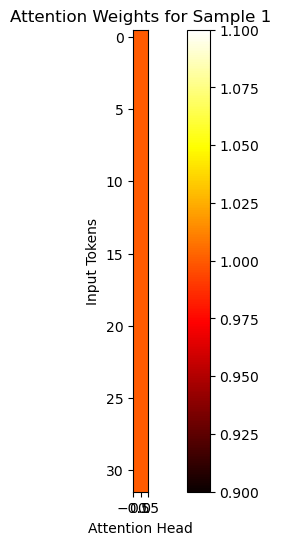

In [124]:
# Cell 8: Model Training
# Model Training with Attention
def train_model_with_attention(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler=None):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        
        for batch_features, batch_labels in progress_bar:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Add sequence length dimension if missing
            batch_features = batch_features.unsqueeze(1)  # Shape: [batch_size, 1, input_dim]

            optimizer.zero_grad()
            outputs, _ = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.numel()

            progress_bar.set_postfix({"Train Loss": loss.item()})

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        
        with torch.no_grad():
            for batch_features, batch_labels in val_progress_bar:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Add sequence length dimension if missing
                batch_features = batch_features.unsqueeze(1)  # Shape: [batch_size, 1, input_dim]

                outputs, _ = model(batch_features)
                loss = criterion(outputs, batch_labels)
                running_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.numel()

                val_progress_bar.set_postfix({"Val Loss": loss.item()})

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if scheduler:
            scheduler.step()

        logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                    f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Model Evaluation with Attention Visualization
def evaluate_model_with_attention(model, test_loader, mlb):
    model.eval()
    all_preds, all_labels, all_attention_weights = [], [], []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)

            # Add sequence length dimension if missing
            batch_features = batch_features.unsqueeze(1)  # Shape: [batch_size, 1, input_dim]

            outputs, attention_weights = model(batch_features)
            preds = (outputs > 0.5).float().cpu().numpy()

            all_preds.append(preds)
            all_labels.append(batch_labels.cpu().numpy())
            all_attention_weights.append(attention_weights.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Calculate metrics (precision, recall, etc.)
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    roc_auc = roc_auc_score(all_labels, all_preds, average='micro', multi_class='ovo')
    loss = hamming_loss(all_labels, all_preds)

    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"Hamming Loss: {loss:.4f}")

    # Example of attention weight visualization (optional)
    attention_sample = all_attention_weights[0]
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_sample, cmap='hot', interpolation='nearest')
    plt.title('Attention Weights for Sample 1')
    plt.xlabel('Attention Head')
    plt.ylabel('Input Tokens')
    plt.colorbar()
    plt.show()

    return all_preds, all_labels

# Initialize model, loss function, and optimizer
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = 768  # PubMedBERT embedding dimension
num_classes = y_train.shape[1]

model = ICDClassifierWithAttention(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = FocalLoss(gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_attention(
    model, train_loader, val_loader, num_epochs=50, criterion=criterion, optimizer=optimizer
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model and visualize attention
all_preds, all_labels = evaluate_model_with_attention(model, test_loader, mlb)

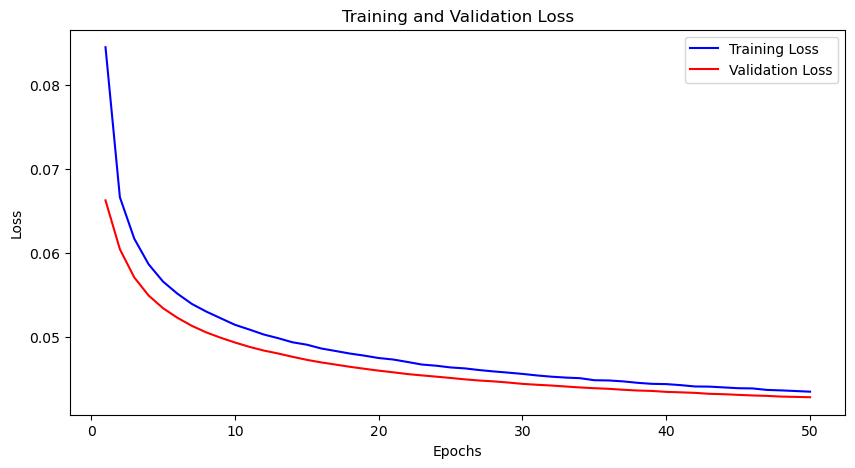

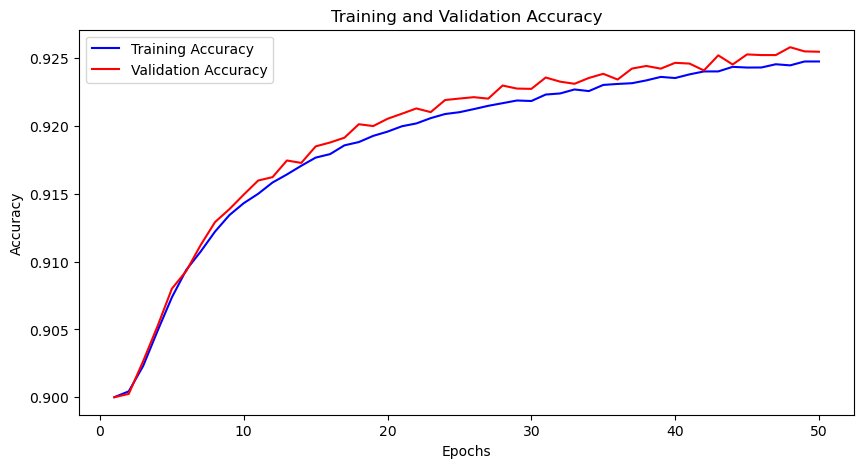

In [125]:
# Cell 9: Plotting Training/Validation Accuracy and Loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

2024-09-17 09:42:03,310 - INFO - Precision: 0.9323
2024-09-17 09:42:03,311 - INFO - Recall: 0.2746
2024-09-17 09:42:03,311 - INFO - F1 Score: 0.4243
2024-09-17 09:42:03,312 - INFO - ROC AUC: 0.6362
2024-09-17 09:42:03,312 - INFO - Hamming Loss: 0.0745
C:\Users\Sabarinath\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating embeddings: 100%|█████████████████████████████████████████████████████████| 313/313 [00:05<00:00, 58.90it/s]


C:\Users\Sabarinath\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating embeddings: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]


SHAP values shape: (50, 1, 768, 10)
Embeddings shape: (50, 1, 768)
Reduced SHAP values shape: (50, 1, 768)
Squeezed SHAP values shape: (50, 1, 768)
Squeezed Embeddings shape: (50, 768)
SHAP values for class: 30500


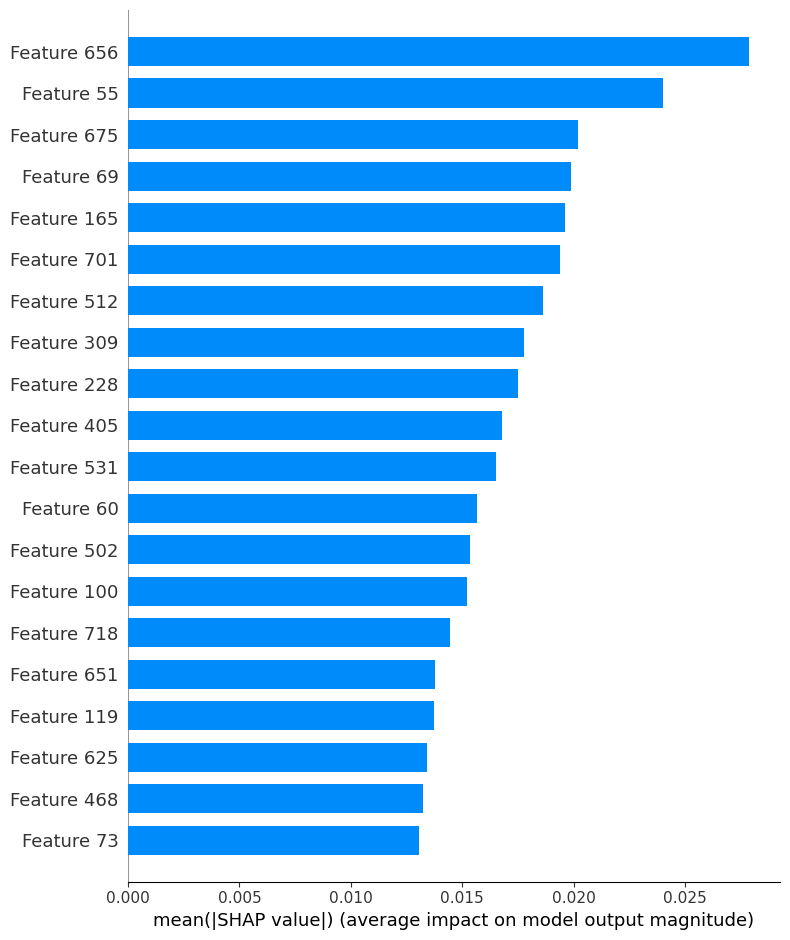

SHAP values for class: 311


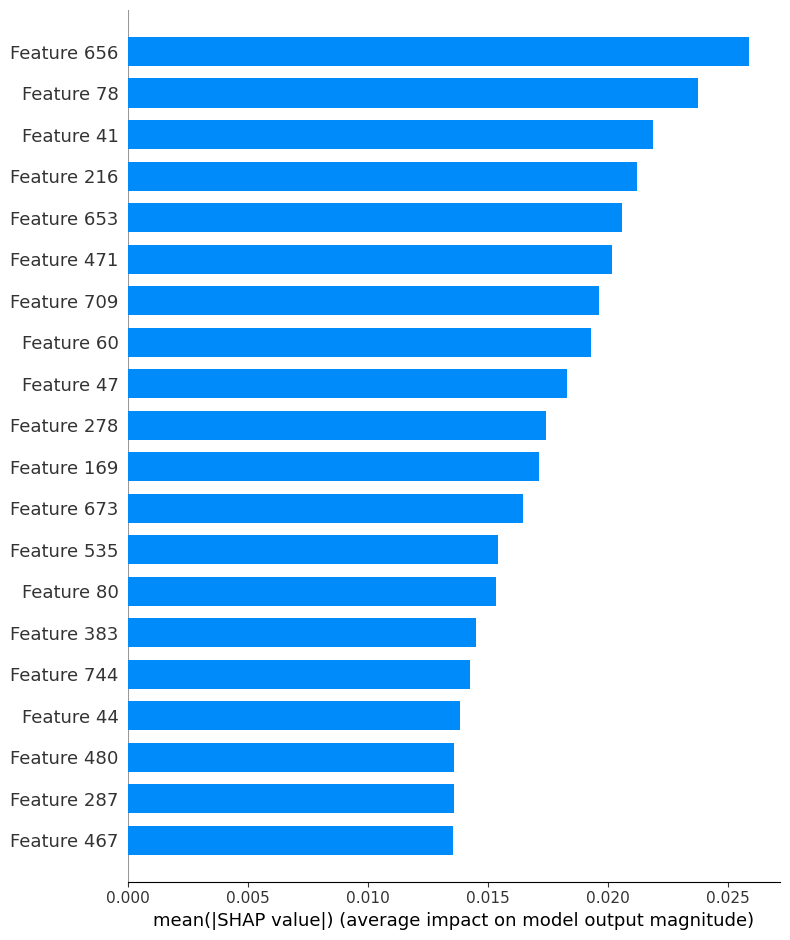

SHAP values for class: 41401


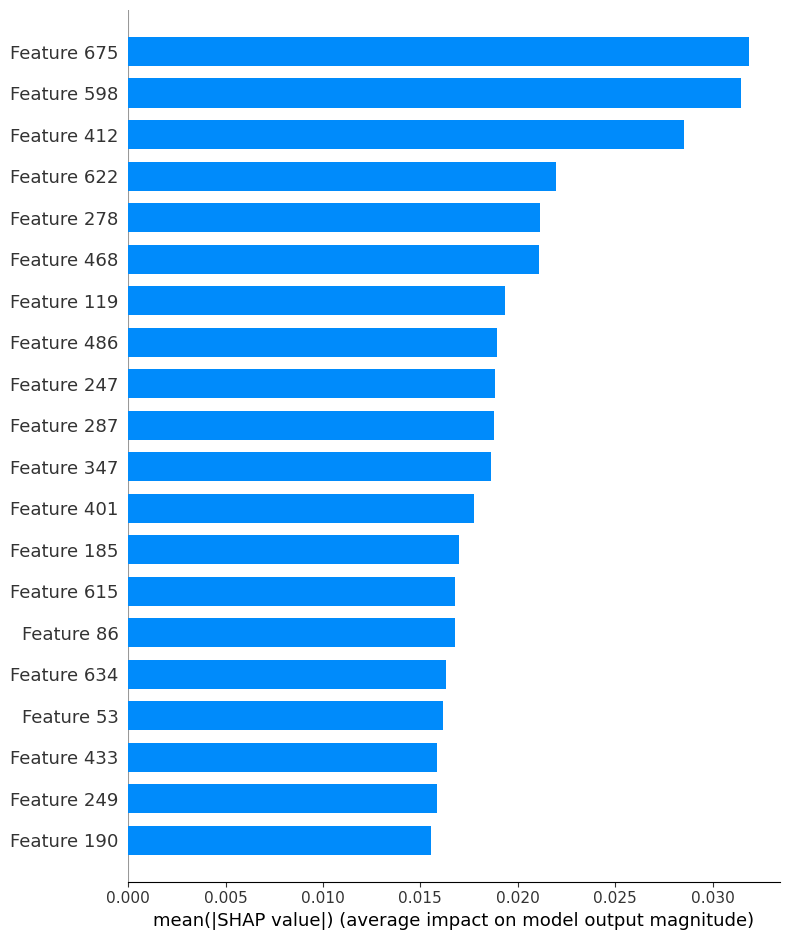

SHAP values for class: 486


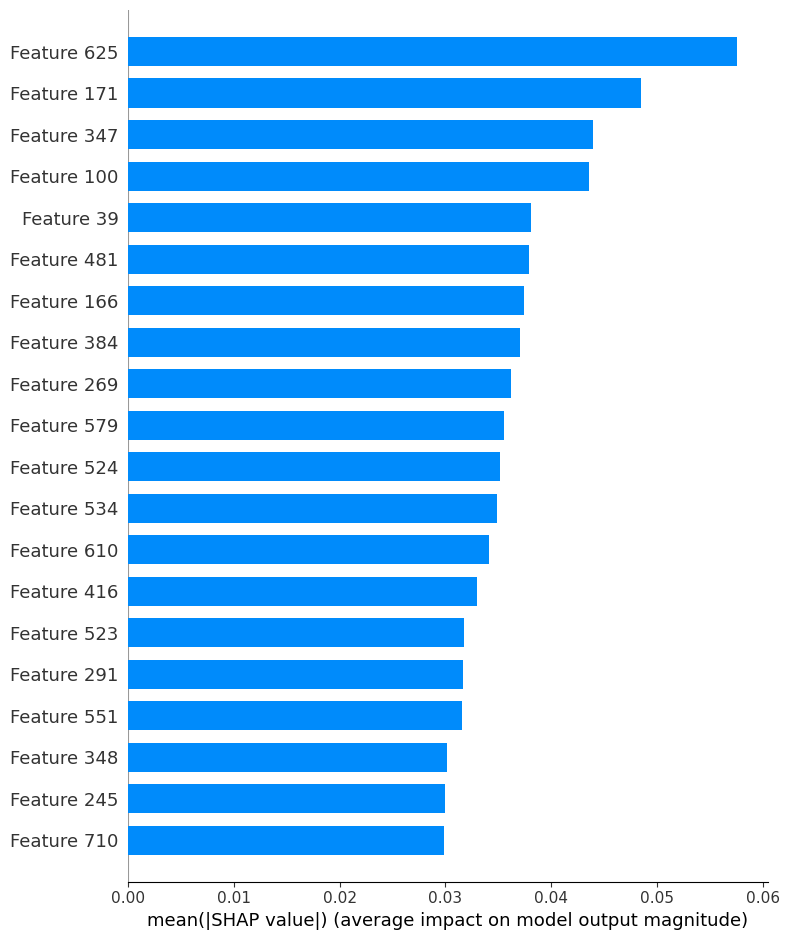

SHAP values for class: 5849


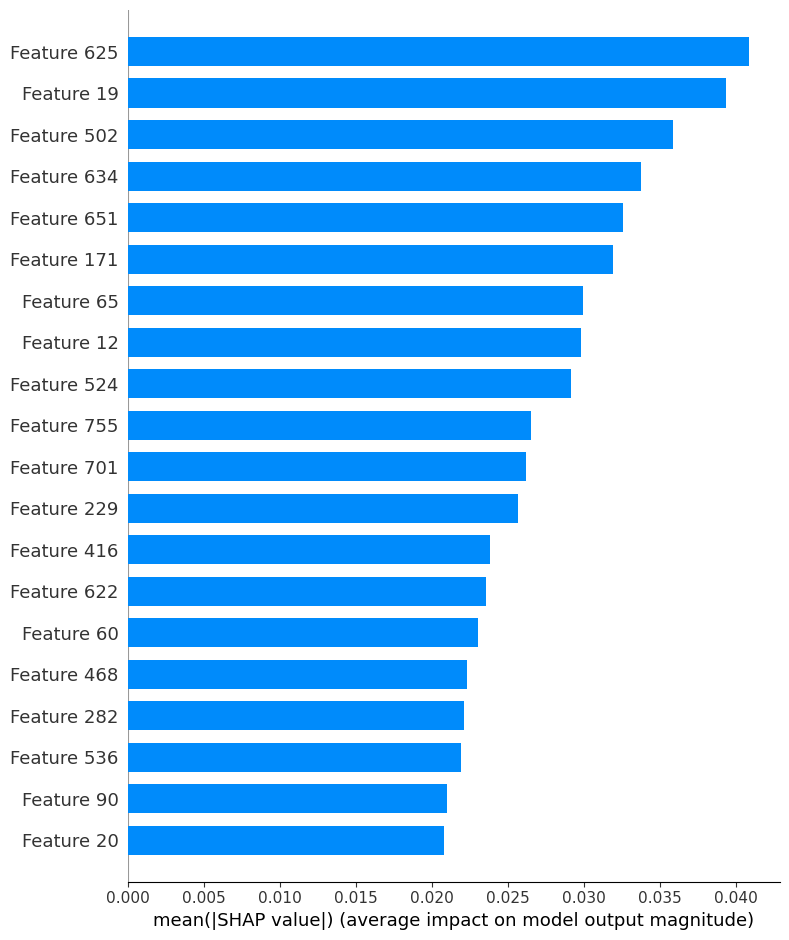

SHAP values for class: 78650


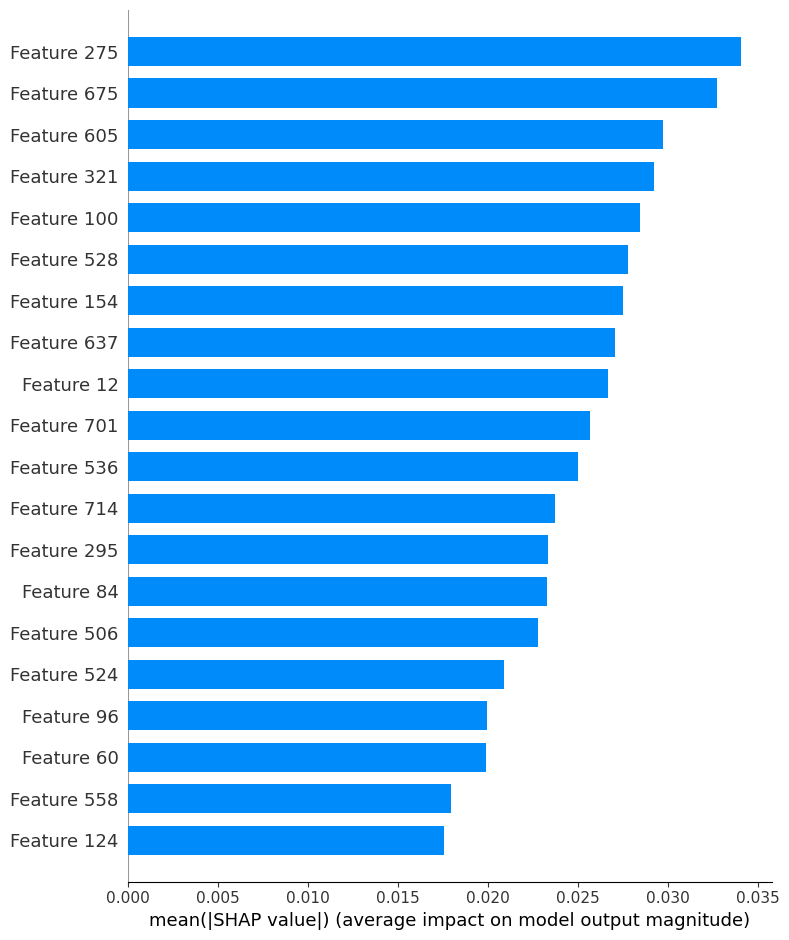

SHAP values for class: 78659


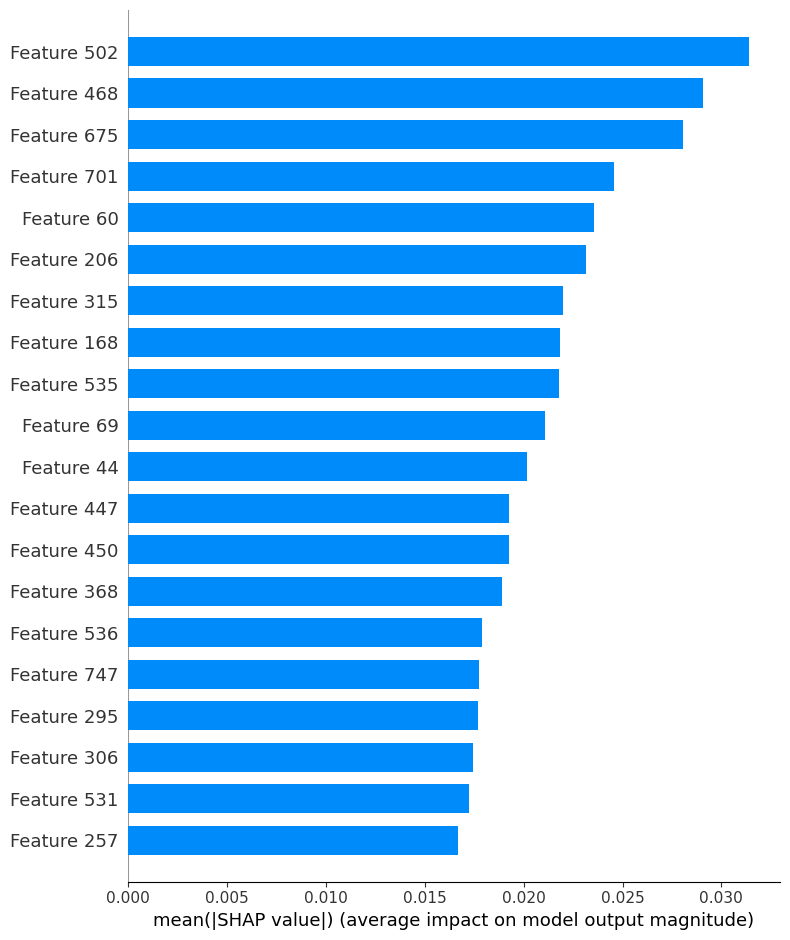

SHAP values for class: A419


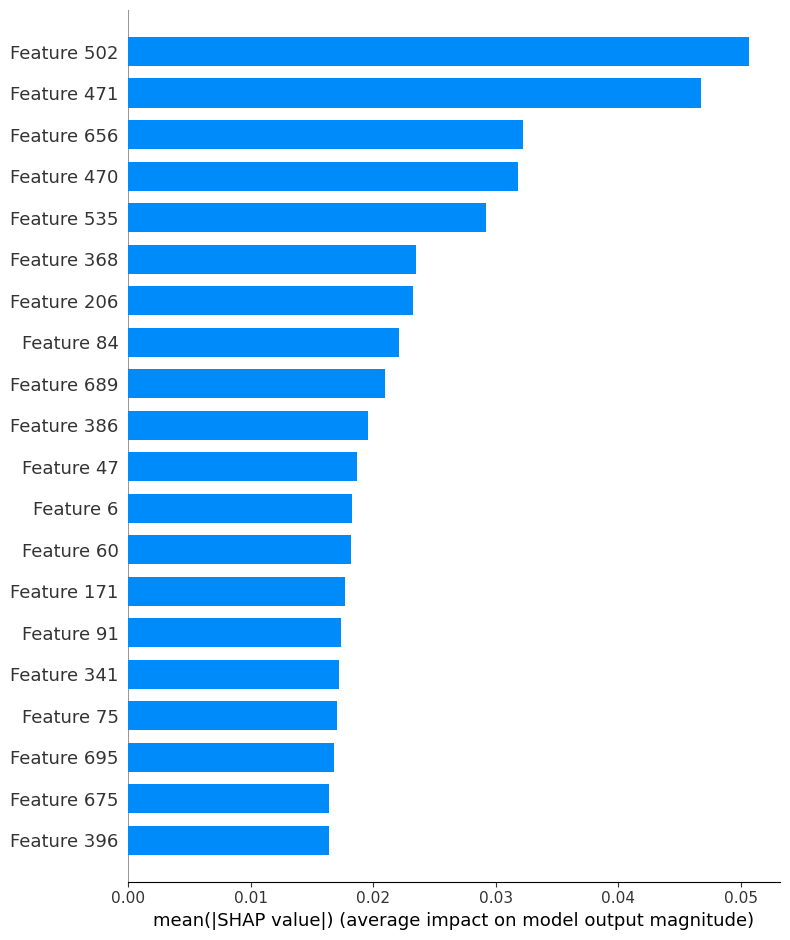

SHAP values for class: F329


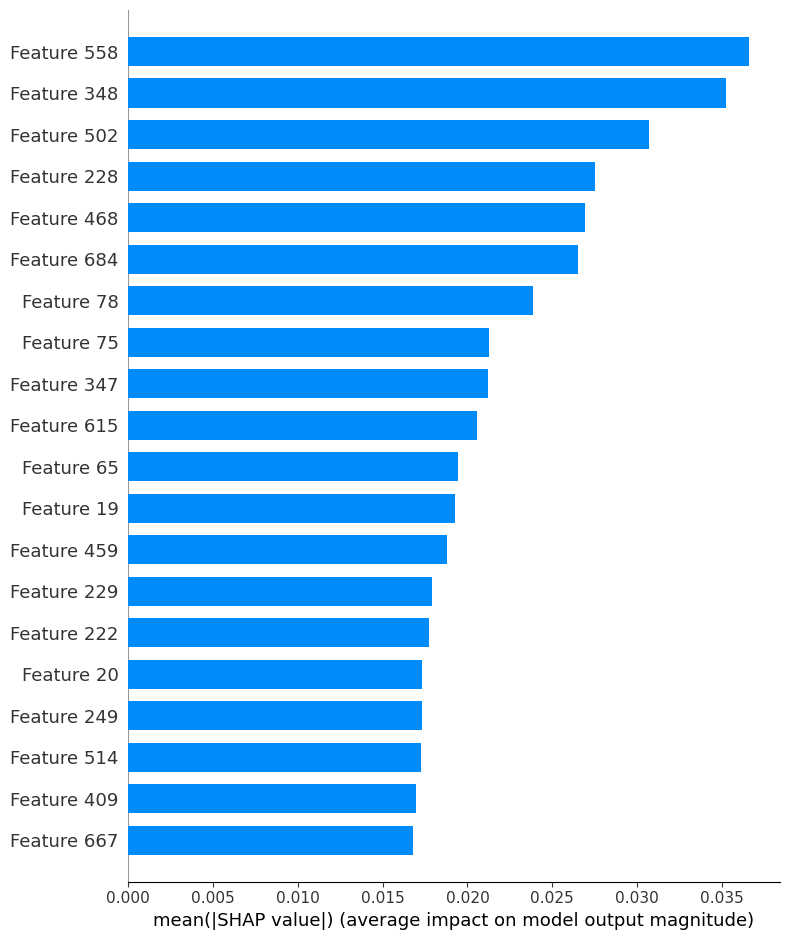

SHAP values for class: Z5111


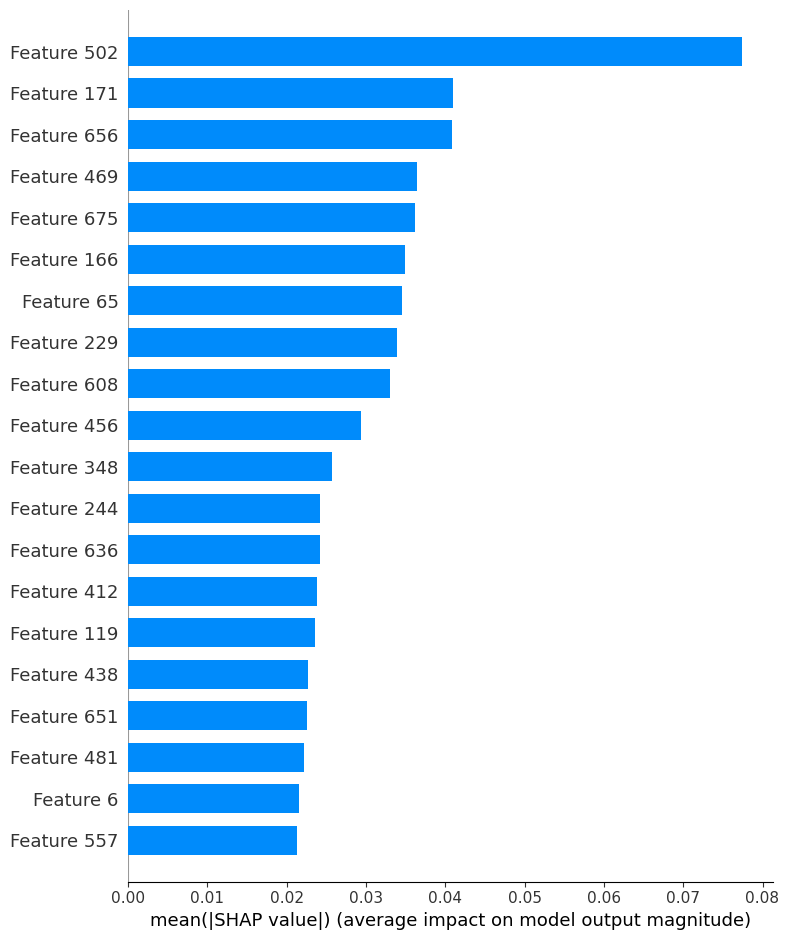

In [126]:
import torch
import shap
import numpy as np
from lime.lime_text import LimeTextExplainer
from torch import nn
from transformers import AutoTokenizer


# LIME Explanation
def interpret_model_with_lime(model, sample_text, mlb, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    
    def predict_proba(texts):
        # Convert text to PubMedBERT embeddings
        embeddings = torch.tensor(get_pubmedbert_embeddings(texts)).to(device)
        
        # Ensure embedding shape is correct
        if len(embeddings.shape) == 2:
            embeddings = embeddings.unsqueeze(1)
        
        with torch.no_grad():
            outputs, _ = model(embeddings)
            return torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities

    exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
    exp.show_in_notebook()

    
# SHAP Explanation for PyTorch models with multi-label classification
def interpret_model_with_shap(model, test_texts, mlb):
    # Convert test_texts to embeddings
    embeddings = torch.tensor(get_pubmedbert_embeddings(test_texts)).to(device)

    # Ensure embeddings have a sequence length dimension
    if len(embeddings.shape) == 2:
        embeddings = embeddings.unsqueeze(1)

    # Model Wrapper to get logits
    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model

        def forward(self, x):
            logits, _ = self.model(x)  # Get only the logits from model
            return logits

    wrapped_model = ModelWrapper(model)

    # Create SHAP explainer
    explainer = shap.DeepExplainer(wrapped_model, embeddings)

    # Compute SHAP values
    shap_values = explainer.shap_values(embeddings.cpu())

    # Debug: Print shapes
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Embeddings shape: {embeddings.cpu().numpy().shape}")

    # Reshape SHAP values to match embeddings
    reduced_shap_values = np.mean(shap_values, axis=-1)
    print(f"Reduced SHAP values shape: {reduced_shap_values.shape}")

    embeddings_flat = embeddings.squeeze(1).cpu().numpy()  # Flatten embeddings

    # Check shapes after squeezing
    print(f"Squeezed SHAP values shape: {reduced_shap_values.shape}")
    print(f"Squeezed Embeddings shape: {embeddings_flat.shape}")

    # Handle multi-label classification
    if isinstance(reduced_shap_values, list) and len(reduced_shap_values) == 1:
        print("SHAP values for binary or single-label classification")
        shap.summary_plot(reduced_shap_values[0], embeddings_flat)  # Default beeswarm plot
    else:
        for i, class_name in enumerate(mlb.classes_):
            if i < len(reduced_shap_values):
                print(f"SHAP values for class: {class_name}")
                shap.summary_plot(reduced_shap_values[i], embeddings_flat, plot_type="bar")  # Beeswarm/bar plot
            else:
                print(f"Skipping class: {class_name}, no corresponding SHAP values found.")

                
# Evaluate model and explain with LIME and SHAP
def evaluate_and_explain_model(model, test_loader, mlb, df):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)

            # Add sequence length dimension if missing
            if len(batch_features.shape) == 2:
                batch_features = batch_features.unsqueeze(1)

            outputs, _ = model(batch_features)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(batch_labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    roc_auc = roc_auc_score(all_labels, all_preds, average='micro', multi_class='ovo')
    loss = hamming_loss(all_labels, all_preds)

    logger.info(f"Precision: {precision:.4f}")
    logger.info(f"Recall: {recall:.4f}")
    logger.info(f"F1 Score: {f1:.4f}")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"Hamming Loss: {loss:.4f}")

    # Sample text for LIME explanation
    sample_text = df['processed_text'].sample(1).values[0]
    interpret_model_with_lime(model, sample_text, mlb, mlb.classes_)

    # SHAP explanation for a batch of texts
    interpret_model_with_shap(model, df['processed_text'].sample(50).values, mlb)

    return all_preds, all_labels

# Call the evaluation and explanation function
all_preds, all_labels = evaluate_and_explain_model(model, test_loader, mlb, df)